In [ ]:
#| default_exp models.timemixer

# TimeMixer

Seasonal and trend components exhibit significantly different characteristics in time series, and different scales of the time series reflect different properties, with seasonal characteristics being more pronounced at a fine-grained micro scale and trend characteristics being more pronounced at a coarse macro scale, it is therefore necessary to decouple seasonal and trend components at different scales. As such, TimeMixer is an MLP-based architecture with Past-Decomposable-Mixing (PDM) and Future-Multipredictor-Mixing (FMM) blocks to take full advantage of disentangled multiscale series in both past extraction and future prediction phases.

**Reference**
- [Shiyu Wang, Haixu Wu, Xiaoming Shi, Tengge Hu, Huakun Luo, Lintao Ma, James Y. Zhang, Jun Zhou."TimeMixer: Decomposable Multiscale Mixing For Time Series Forecasting"](https://openreview.net/pdf?id=7oLshfEIC2)

![Figure 1. Architecture of SOFTS.](imgs_models/timemixer.png)

In [ ]:
#| export

import numpy as np

import torch
import torch.nn as nn

from neuralforecast.common._base_multivariate import BaseMultivariate
from neuralforecast.common._modules import PositionalEmbedding, TokenEmbedding, TemporalEmbedding, SeriesDecomp

from neuralforecast.losses.pytorch import MAE

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Auxiliary functions
### Normalization

In [ ]:
#| export

class Normalize(nn.Module):
    """
    Normalize
    """
    def __init__(self, num_features: int, eps=1e-5, affine=False, subtract_last=False, non_norm=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(Normalize, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

### Embedding

In [ ]:
#| export

class DataEmbedding_wo_pos(nn.Module):
    """
    DataEmbedding_wo_pos
    """
    def __init__(self, c_in, d_model, dropout=0.1, embed_type='fixed', freq='h'):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, hidden_size=d_model)
        self.position_embedding = PositionalEmbedding(hidden_size=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x is None and x_mark is not None:
            return self.temporal_embedding(x_mark)
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

### DFT decomposition

In [ ]:
#| export

class DFT_series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, top_k):
        super(DFT_series_decomp, self).__init__()
        self.top_k = top_k

    def forward(self, x):
        xf = torch.fft.rfft(x)
        freq = abs(xf)
        freq[0] = 0
        top_k_freq, top_list = torch.topk(freq, self.top_k)
        xf[freq <= top_k_freq.min()] = 0
        x_season = torch.fft.irfft(xf)
        x_trend = x - x_season
        return x_season, x_trend

### Mixing

In [ ]:
#| export

class MultiScaleSeasonMixing(nn.Module):
    """
    Bottom-up mixing season pattern
    """

    def __init__(self, seq_len, down_sampling_window, down_sampling_layers):
        super(MultiScaleSeasonMixing, self).__init__()

        self.down_sampling_layers = torch.nn.ModuleList(
            [
                nn.Sequential(
                    torch.nn.Linear(
                        seq_len // (down_sampling_window ** i),
                        seq_len // (down_sampling_window ** (i + 1)),
                    ),
                    nn.GELU(),
                    torch.nn.Linear(
                        seq_len // (down_sampling_window ** (i + 1)),
                        seq_len // (down_sampling_window ** (i + 1)),
                    ),

                )
                for i in range(down_sampling_layers)
            ]
        )

    def forward(self, season_list):

        # mixing high->low
        out_high = season_list[0]
        out_low = season_list[1]
        out_season_list = [out_high.permute(0, 2, 1)]

        for i in range(len(season_list) - 1):
            out_low_res = self.down_sampling_layers[i](out_high)
            out_low = out_low + out_low_res
            out_high = out_low
            if i + 2 <= len(season_list) - 1:
                out_low = season_list[i + 2]
            out_season_list.append(out_high.permute(0, 2, 1))

        return out_season_list


class MultiScaleTrendMixing(nn.Module):
    """
    Top-down mixing trend pattern
    """

    def __init__(self, seq_len, down_sampling_window, down_sampling_layers):
        super(MultiScaleTrendMixing, self).__init__()

        self.up_sampling_layers = torch.nn.ModuleList(
            [
                nn.Sequential(
                    torch.nn.Linear(
                        seq_len // (down_sampling_window ** (i + 1)),
                        seq_len // (down_sampling_window ** i),
                    ),
                    nn.GELU(),
                    torch.nn.Linear(
                        seq_len // (down_sampling_window ** i),
                        seq_len // (down_sampling_window ** i),
                    ),
                )
                for i in reversed(range(down_sampling_layers))
            ])

    def forward(self, trend_list):

        # mixing low->high
        trend_list_reverse = trend_list.copy()
        trend_list_reverse.reverse()
        out_low = trend_list_reverse[0]
        out_high = trend_list_reverse[1]
        out_trend_list = [out_low.permute(0, 2, 1)]

        for i in range(len(trend_list_reverse) - 1):
            out_high_res = self.up_sampling_layers[i](out_low)
            out_high = out_high + out_high_res
            out_low = out_high
            if i + 2 <= len(trend_list_reverse) - 1:
                out_high = trend_list_reverse[i + 2]
            out_trend_list.append(out_low.permute(0, 2, 1))

        out_trend_list.reverse()
        return out_trend_list


class PastDecomposableMixing(nn.Module):
    """
    PastDecomposableMixing
    """
    def __init__(self, seq_len, pred_len, down_sampling_window, down_sampling_layers, 
                 d_model, dropout, channel_independence, decomp_method, d_ff, moving_avg, top_k):
        super(PastDecomposableMixing, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.down_sampling_window = down_sampling_window
        self.down_sampling_layers = down_sampling_layers

        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.channel_independence = channel_independence

        if decomp_method == 'moving_avg':
            self.decompsition = SeriesDecomp(moving_avg)
        elif decomp_method == "dft_decomp":
            self.decompsition = DFT_series_decomp(top_k)
        else:
            raise ValueError('decompsition is error')

        if self.channel_independence == 0:
            self.cross_layer = nn.Sequential(
                nn.Linear(in_features=d_model, out_features=d_ff),
                nn.GELU(),
                nn.Linear(in_features=d_ff, out_features=d_model),
            )

        # Mixing season
        self.mixing_multi_scale_season = MultiScaleSeasonMixing(self.seq_len, self.down_sampling_window, self.down_sampling_layers)

        # Mxing trend
        self.mixing_multi_scale_trend = MultiScaleTrendMixing(self.seq_len, self.down_sampling_window, self.down_sampling_layers)

        self.out_cross_layer = nn.Sequential(
            nn.Linear(in_features=d_model, out_features=d_ff),
            nn.GELU(),
            nn.Linear(in_features=d_ff, out_features=d_model),
        )

    def forward(self, x_list):
        length_list = []
        for x in x_list:
            _, T, _ = x.size()
            length_list.append(T)

        # Decompose to obtain the season and trend
        season_list = []
        trend_list = []
        for x in x_list:
            season, trend = self.decompsition(x)
            if self.channel_independence == 0:
                season = self.cross_layer(season)
                trend = self.cross_layer(trend)
            season_list.append(season.permute(0, 2, 1))
            trend_list.append(trend.permute(0, 2, 1))

        # bottom-up season mixing
        out_season_list = self.mixing_multi_scale_season(season_list)
        # top-down trend mixing
        out_trend_list = self.mixing_multi_scale_trend(trend_list)

        out_list = []
        for ori, out_season, out_trend, length in zip(x_list, out_season_list, out_trend_list,
                                                      length_list):
            out = out_season + out_trend
            if self.channel_independence:
                out = ori + self.out_cross_layer(out)
            out_list.append(out[:, :length, :])
        return out_list

## 2. Model

In [ ]:
#| export

class TimeMixer(BaseMultivariate):
    """ TimeMixer
    **Parameters**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `n_series`: int, number of time-series.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `d_model`: int, dimension of the model.<br>
    `d_ff`: int, dimension of the fully-connected network.<br>
    `dropout`: float, dropout rate.<br>
    `e_layers`: int, number of encoder layers.<br>
    `top_k`: int, number of selected frequencies.<br>
    `decomp_method`: str, method of series decomposition [moving_avg, dft_decomp].<br>
    `moving_avg`: int, window size of moving average.<br>
    `channel_independence`: int, 0: channel dependence, 1: channel independence.<br>
    `down_sampling_layers`: int, number of downsampling layers.<br>
    `down_sampling_window`: int, size of downsampling window.<br>
    `down_sampling_method`: str, down sampling method [avg, max, conv].<br>
    `use_norm`: bool, whether to normalize or not.<br>
	`decoder_input_size_multiplier`: float = 0.5.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

    **References**<br>
    [Shiyu Wang, Haixu Wu, Xiaoming Shi, Tengge Hu, Huakun Luo, Lintao Ma, James Y. Zhang, Jun Zhou."TimeMixer: Decomposable Multiscale Mixing For Time Series Forecasting"](https://openreview.net/pdf?id=7oLshfEIC2)
    """

    # Class attributes
    SAMPLING_TYPE = 'multivariate'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(self,
                 h,
                 input_size,
                 n_series,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 d_model: int = 32,
                 d_ff: int = 32,
                 dropout: float = 0.1,
                 e_layers: int = 4,
                 top_k: int = 5,
                 decomp_method: str = 'moving_avg',
                 moving_avg: int = 25,
                 channel_independence: int = 0,
                 down_sampling_layers: int = 1,
                 down_sampling_window: int = 2,
                 down_sampling_method: str = 'avg',
                 use_norm: bool = True,
                 decoder_input_size_multiplier: float = 0.5,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,            
                 **trainer_kwargs):
        
        super(TimeMixer, self).__init__(h=h,
                                    input_size=input_size,
                                    n_series=n_series,
                                    stat_exog_list = stat_exog_list,
                                    futr_exog_list = futr_exog_list,
                                    hist_exog_list = hist_exog_list,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    random_seed=random_seed,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    lr_scheduler=lr_scheduler,
                                    lr_scheduler_kwargs=lr_scheduler_kwargs,
                                    **trainer_kwargs)
        
        self.label_len = int(np.ceil(input_size * decoder_input_size_multiplier))
        if (self.label_len >= input_size) or (self.label_len <= 0):
            raise Exception(f'Check decoder_input_size_multiplier={decoder_input_size_multiplier}, range (0,1)')
        
        self.h = h
        self.input_size = input_size
        self.e_layers = e_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = dropout
        self.top_k = top_k

        self.use_norm = use_norm

        self.use_future_temporal_feature = 0
        if futr_exog_list is not None:
            self.use_future_temporal_feature = 1

        self.decomp_method = decomp_method
        self.moving_avg = moving_avg
        self.channel_independence = channel_independence

        self.down_sampling_layers = down_sampling_layers
        self.down_sampling_window = down_sampling_window
        self.down_sampling_method = down_sampling_method

        self.pdm_blocks = nn.ModuleList([PastDecomposableMixing(self.input_size, self.h, self.down_sampling_window, self.down_sampling_layers, self.d_model, self.dropout, self.channel_independence, self.decomp_method, self.d_ff, self.moving_avg, self.top_k)
                                         for _ in range(self.e_layers)])
        
        self.preprocess = SeriesDecomp(self.moving_avg)
        self.enc_in = n_series
        self.c_out = n_series

        if self.channel_independence == 1:
            self.enc_embedding = DataEmbedding_wo_pos(1, self.d_model, self.dropout)
        else:
            self.enc_embedding = DataEmbedding_wo_pos(self.enc_in, self.d_model, self.dropout)

        self.normalize_layers = torch.nn.ModuleList(
            [
                Normalize(self.enc_in, affine=True, non_norm=False if self.use_norm else True)
                for i in range(self.down_sampling_layers + 1)
            ]
        )

        self.predict_layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(
                    self.input_size // (self.down_sampling_window ** i),
                    self.h,
                )
                for i in range(self.down_sampling_layers + 1)
            ]
        )

        if self.channel_independence == 1:
            self.projection_layer = nn.Linear(
                self.d_model, 1, bias=True)
        else:
            self.projection_layer = nn.Linear(
                self.d_model, self.c_out, bias=True)

            self.out_res_layers = torch.nn.ModuleList([
                torch.nn.Linear(
                    self.input_size // (self.down_sampling_window ** i),
                    self.input_size // (self.down_sampling_window ** i),
                )
                for i in range(self.down_sampling_layers + 1)
            ])

            self.regression_layers = torch.nn.ModuleList(
                [
                    torch.nn.Linear(
                        self.input_size // (self.down_sampling_window ** i),
                        self.h,
                    )
                    for i in range(self.down_sampling_layers + 1)
                ]
            )

    def out_projection(self, dec_out, i, out_res):
        dec_out = self.projection_layer(dec_out)
        out_res = out_res.permute(0, 2, 1)
        out_res = self.out_res_layers[i](out_res)
        out_res = self.regression_layers[i](out_res).permute(0, 2, 1)
        dec_out = dec_out + out_res
        return dec_out
    
    def pre_enc(self, x_list):
        if self.channel_independence == 1:
            return (x_list, None)
        else:
            out1_list = []
            out2_list = []
            for x in x_list:
                x_1, x_2 = self.preprocess(x)
                out1_list.append(x_1)
                out2_list.append(x_2)
            return (out1_list, out2_list)
        
    def __multi_scale_process_inputs(self, x_enc, x_mark_enc):
        if self.down_sampling_method == 'max':
            down_pool = torch.nn.MaxPool1d(self.down_sampling_window, return_indices=False)
        elif self.down_sampling_method == 'avg':
            down_pool = torch.nn.AvgPool1d(self.down_sampling_window)
        elif self.down_sampling_method == 'conv':
            padding = 1
            down_pool = nn.Conv1d(in_channels=self.enc_in, out_channels=self.enc_in,
                                  kernel_size=3, padding=padding,
                                  stride=self.down_sampling_window,
                                  padding_mode='circular',
                                  bias=False)
        else:
            return x_enc, x_mark_enc
        # B,T,C -> B,C,T
        x_enc = x_enc.permute(0, 2, 1)

        x_enc_ori = x_enc
        x_mark_enc_mark_ori = x_mark_enc

        x_enc_sampling_list = []
        x_mark_sampling_list = []
        x_enc_sampling_list.append(x_enc.permute(0, 2, 1))
        x_mark_sampling_list.append(x_mark_enc)

        for i in range(self.down_sampling_layers):
            x_enc_sampling = down_pool(x_enc_ori)

            x_enc_sampling_list.append(x_enc_sampling.permute(0, 2, 1))
            x_enc_ori = x_enc_sampling

            if x_mark_enc_mark_ori is not None:
                x_mark_sampling_list.append(x_mark_enc_mark_ori[:, ::self.down_sampling_window, :])
                x_mark_enc_mark_ori = x_mark_enc_mark_ori[:, ::self.down_sampling_window, :]

        x_enc = x_enc_sampling_list
        if x_mark_enc_mark_ori is not None:
            x_mark_enc = x_mark_sampling_list
        else:
            x_mark_enc = x_mark_enc

        return x_enc, x_mark_enc
    
    def forecast(self, x_enc, x_mark_enc, x_mark_dec):

        if self.use_future_temporal_feature:
            if self.channel_independence == 1:
                B, T, N = x_enc.size()
                x_mark_dec = x_mark_dec.repeat(N, 1, 1)
                self.x_mark_dec = self.enc_embedding(None, x_mark_dec)
            else:
                self.x_mark_dec = self.enc_embedding(None, x_mark_dec)

        x_enc, x_mark_enc = self.__multi_scale_process_inputs(x_enc, x_mark_enc)

        x_list = []
        x_mark_list = []
        if x_mark_enc is not None:
            for i, x, x_mark in zip(range(len(x_enc)), x_enc, x_mark_enc):
                B, T, N = x.size()
                x = self.normalize_layers[i](x, 'norm')
                if self.channel_independence == 1:
                    x = x.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)
                    x_mark = x_mark.repeat(N, 1, 1)
                x_list.append(x)
                x_mark_list.append(x_mark)
        else:
            for i, x in zip(range(len(x_enc)), x_enc, ):
                B, T, N = x.size()
                x = self.normalize_layers[i](x, 'norm')
                if self.channel_independence == 1:
                    x = x.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)
                x_list.append(x)

        # embedding
        enc_out_list = []
        x_list = self.pre_enc(x_list)
        if x_mark_enc is not None:
            for i, x, x_mark in zip(range(len(x_list[0])), x_list[0], x_mark_list):
                enc_out = self.enc_embedding(x, x_mark)  # [B,T,C]
                enc_out_list.append(enc_out)
        else:
            for i, x in zip(range(len(x_list[0])), x_list[0]):
                enc_out = self.enc_embedding(x, None)  # [B,T,C]
                enc_out_list.append(enc_out)

        # Past Decomposable Mixing as encoder for past
        for i in range(self.e_layers):
            enc_out_list = self.pdm_blocks[i](enc_out_list)

        # Future Multipredictor Mixing as decoder for future
        dec_out_list = self.future_multi_mixing(B, enc_out_list, x_list)

        dec_out = torch.stack(dec_out_list, dim=-1).sum(-1)
        dec_out = self.normalize_layers[0](dec_out, 'denorm')
        return dec_out
    
    def future_multi_mixing(self, B, enc_out_list, x_list):
        dec_out_list = []
        if self.channel_independence == 1:
            x_list = x_list[0]
            for i, enc_out in zip(range(len(x_list)), enc_out_list):
                dec_out = self.predict_layers[i](enc_out.permute(0, 2, 1)).permute(
                    0, 2, 1)  # align temporal dimension
                if self.use_future_temporal_feature:
                    dec_out = dec_out + self.x_mark_dec
                    dec_out = self.projection_layer(dec_out)
                else:
                    dec_out = self.projection_layer(dec_out)
                dec_out = dec_out.reshape(B, self.c_out, self.h).permute(0, 2, 1).contiguous()
                dec_out_list.append(dec_out)

        else:
            for i, enc_out, out_res in zip(range(len(x_list[0])), enc_out_list, x_list[1]):
                dec_out = self.predict_layers[i](enc_out.permute(0, 2, 1)).permute(
                    0, 2, 1)  # align temporal dimension
                dec_out = self.out_projection(dec_out, i, out_res)
                dec_out_list.append(dec_out)

        return dec_out_list
    
    def forward(self, windows_batch):
        insample_y = windows_batch['insample_y']
        futr_exog = windows_batch['futr_exog']

        if self.futr_exog_size > 0:
            x_mark_enc = futr_exog[:, :, :self.input_size, :]
            x_mark_dec = futr_exog[:, :, -(self.label_len + self.h):, :]
        else:
            x_mark_enc = None
            x_mark_dec = None


        y_pred = self.forecast(insample_y, x_mark_enc, x_mark_dec)
        y_pred = y_pred[:, -self.h:, :]
        y_pred = self.loss.domain_map(y_pred)

        # domain_map might have squeezed the last dimension in case n_series == 1
        if y_pred.ndim == 2:
            return y_pred.unsqueeze(-1)
        else:
            return y_pred

In [ ]:
show_doc(TimeMixer)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/timemixer.py#L329){target="_blank" style="float:right; font-size:smaller"}

### TimeMixer

>      TimeMixer (h, input_size, n_series, stat_exog_list=None,
>                 hist_exog_list=None, futr_exog_list=None, d_model:int=32,
>                 d_ff:int=32, dropout:float=0.1, e_layers:int=4, top_k:int=5,
>                 decomp_method:str='moving_avg', moving_avg:int=25,
>                 channel_independence:int=0, down_sampling_layers:int=1,
>                 down_sampling_window:int=2, down_sampling_method:str='avg',
>                 use_norm:bool=True, decoder_input_size_multiplier:float=0.5,
>                 loss=MAE(), valid_loss=None, max_steps:int=1000,
>                 learning_rate:float=0.001, num_lr_decays:int=-1,
>                 early_stop_patience_steps:int=-1, val_check_steps:int=100,
>                 batch_size:int=32, step_size:int=1,
>                 scaler_type:str='identity', random_seed:int=1,
>                 num_workers_loader:int=0, drop_last_loader:bool=False,
>                 optimizer=None, optimizer_kwargs=None, lr_scheduler=None,
>                 lr_scheduler_kwargs=None, **trainer_kwargs)

TimeMixer
**Parameters**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`n_series`: int, number of time-series.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`d_model`: int, dimension of the model.<br>
`d_ff`: int, dimension of the fully-connected network.<br>
`dropout`: float, dropout rate.<br>
`e_layers`: int, number of encoder layers.<br>
`top_k`: int, number of selected frequencies.<br>
`decomp_method`: str, method of series decomposition [moving_avg, dft_decomp].<br>
`moving_avg`: int, window size of moving average.<br>
`channel_independence`: int, 0: channel dependence, 1: channel independence.<br>
`down_sampling_layers`: int, number of downsampling layers.<br>
`down_sampling_window`: int, size of downsampling window.<br>
`down_sampling_method`: str, down sampling method [avg, max, conv].<br>
`use_norm`: bool, whether to normalize or not.<br>
    `decoder_input_size_multiplier`: float = 0.5.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

**References**<br>
[Shiyu Wang, Haixu Wu, Xiaoming Shi, Tengge Hu, Huakun Luo, Lintao Ma, James Y. Zhang, Jun Zhou."TimeMixer: Decomposable Multiscale Mixing For Time Series Forecasting"](https://openreview.net/pdf?id=7oLshfEIC2)

In [ ]:
show_doc(TimeMixer.fit, name='TimeMixer.fit')

---

### TimeMixer.fit

>      TimeMixer.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                     distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(TimeMixer.predict, name='TimeMixer.predict')

---

### TimeMixer.predict

>      TimeMixer.predict (dataset, test_size=None, step_size=1,
>                         random_seed=None, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## 3. Usage example

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params
----------------------------------------------------------
0 | loss             | MAE                  | 0     
1 | valid_loss       | MAE                  | 0     
2 | padder           | ConstantPad1d        | 0     
3 | scaler           | TemporalNorm         | 0     
4 | pdm_blocks       | ModuleList           | 14.2 K
5 | preprocess       | SeriesDecomp         | 0     
6 | enc_embedding    | DataEmbedding_wo_pos | 2.5 K 
7 | normalize_layers | ModuleList           | 8     
8 | predict_layers   | ModuleList           | 456   
9 | projection_layer | Linear               | 33    
----------------------------------------------------------
14.8 K    Trainable params
2.4 K     Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


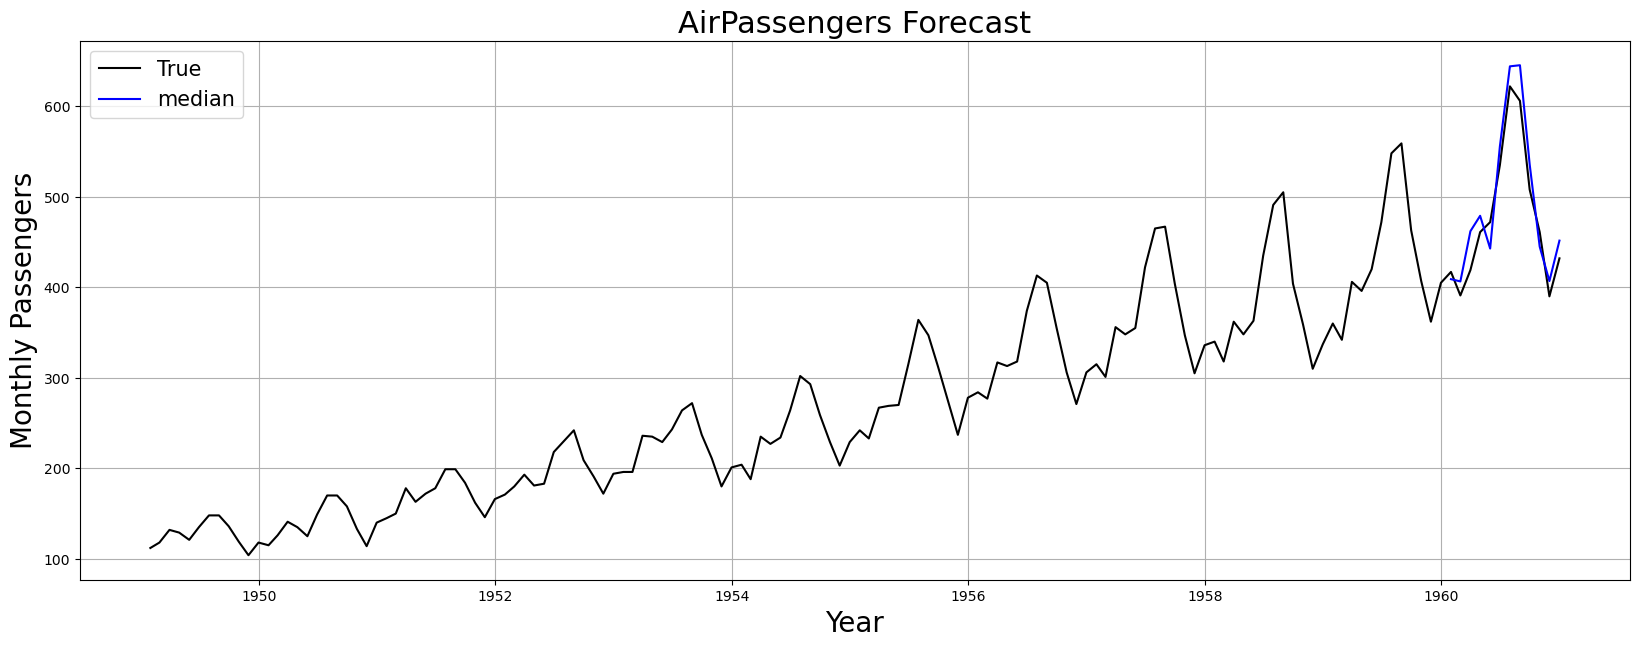

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import TimeMixer
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MAE

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = TimeMixer(h=12,
                input_size=24,
                n_series=2,
                scaler_type='standard',
                max_steps=500,
                early_stop_patience_steps=-1,
                val_check_steps=5,
                learning_rate=1e-3,
                loss = MAE(),
                valid_loss=MAE(),
                batch_size=32
                )

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['TimeMixer'], c='blue', label='median')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Using `cross_validation` to forecast multiple historic values.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name              | Type                 | Params
------------------------------------------------------------
0  | loss              | MAE                  | 0     
1  | valid_loss        | MAE                  | 0     
2  | padder            | ConstantPad1d        | 0     
3  | scaler            | TemporalNorm         | 0     
4  | pdm_blocks        | ModuleList           | 22.6 K
5  | preprocess        | SeriesDecomp         | 0     
6  | enc_embedding     | DataEmbedding_wo_pos | 2.6 K 
7  | normalize_layers  | ModuleList           | 8     
8  | predict_layers    | ModuleList           | 456   
9  | projection_layer  | Linear               | 66    
10 | out_res_layers    | ModuleList           | 756   
11 | regression_layers | ModuleList           | 456   
------------------------------------------------------------
24.6 K    T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


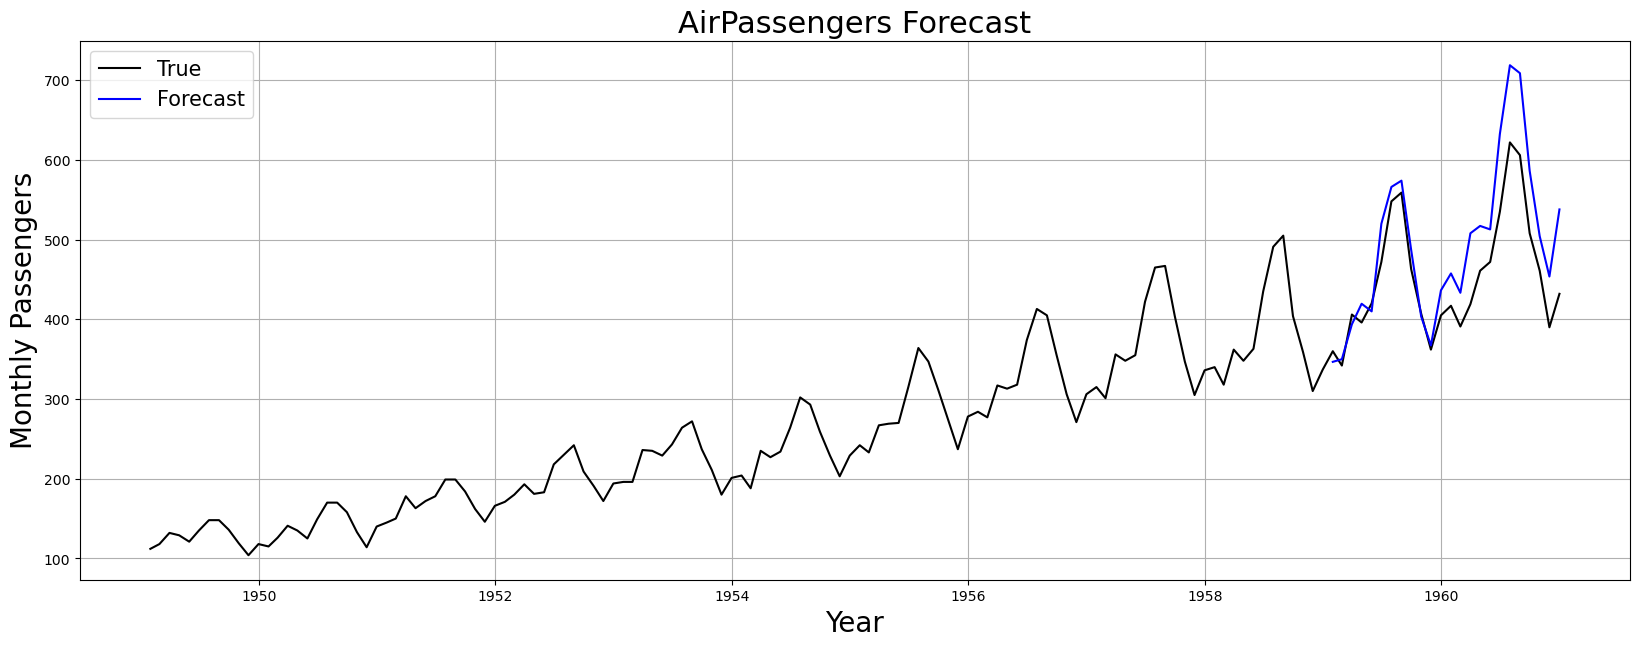

In [ ]:
#| eval: false
fcst = NeuralForecast(models=[model], freq='M')
forecasts = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=2, step_size=12)

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.loc['Airline1']
Y_df = AirPassengersPanel[AirPassengersPanel['unique_id']=='Airline1']

plt.plot(Y_df['ds'], Y_df['y'], c='black', label='True')
plt.plot(Y_hat_df['ds'], Y_hat_df['TimeMixer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()